In [33]:
!pip install leafmap
!pip install geopandas osmnx

In [34]:
import numpy as np
import pandas as pd
import leafmap
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.cluster import KMeans
import folium

In [35]:


# bike data extracted from
# https://data.smartdublin.ie/dataset/dublinbikes-api

data_bike_may_2024 = 'https://data.smartdublin.ie/dataset/33ec9fe2-4957-4e9a-ab55-c5e917c7a9ab/resource/87a171b3-82b1-4e47-9b36-75e579adf3f9/download/dublin-bikes_station_status_052024.csv'
data_weather_may_2024 = 'data_weather_may_2024.csv'

df24 = pd.read_csv(data_bike_may_2024)
df24_bike = pd.read_csv(data_bike_may_2024)
# df24_weather = pd.read_csv(data_weather_may_2024)

df24.sample(5)
df24_bike.sample(5)
# print(df24)
# print(df24_weather)
df24_bike

,system_id,last_reported,station_id,num_bikes_available,num_docks_available,is_installed,is_renting,is_returning,name,short_name,address,lat,lon,region_id,capacity
0,dublin_bikes,2024-05-02 19:00:00,109,10,18,True,True,True,BUCKINGHAM STREET LOWER,NaN,Buckingham Street Lower,53.353333,-6.249319,NaN,29
1,dublin_bikes,2024-05-02 19:00:00,110,22,18,True,True,True,PHIBSBOROUGH ROAD,NaN,Phibsborough Road,53.356308,-6.273717,NaN,40
2,dublin_bikes,2024-05-02 19:00:00,116,7,23,True,True,True,BROADSTONE,NaN,Broadstone,53.354700,-6.272314,NaN,30
3,dublin_bikes,2024-05-02 19:00:00,54,1,32,True,True,True,CLONMEL STREET,NaN,Clonmel Street,53.336020,-6.262980,NaN,33
4,dublin_bikes,2024-05-02 19:00:00,58,1,39,True,True,True,SIR PATRICK DUN'S,NaN,Sir Patrick's Dun,53.339220,-6.240642,NaN,40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
596225,dublin_bikes,2024-05-31 23:55:00,82,12,10,True,True,True,MOUNT BROWN,NaN,Mount Brown,53.341644,-6.297190,NaN,22
596226,dublin_bikes,2024-05-31 23:55:00,87,17,21,True,True,True,COLLINS BARRACKS MUSEUM,NaN,Collins Barracks Museum,53.347477,-6.285250,NaN,38
596227,dublin_bikes,2024-05-31 23:55:00,92,37,3,True,True,True,HEUSTON BRIDGE (NORTH),NaN,Heuston Bridge (North),53.347800,-6.292432,NaN,40
596228,dublin_bikes,2024-05-31 23:55:00,94,40,0,True,True,True,HEUSTON STATION (CAR PARK),NaN,Heuston Station (Car Park),53.346985,-6.297804,NaN,40


In [36]:
# Data cleaning step
df24_bike['last_reported'] = pd.to_datetime(df24_bike['last_reported'])
df24_bike['hour'] = df24_bike['last_reported'].dt.hour
df24_bike['date_hour'] = df24_bike['last_reported'].dt.strftime('%Y-%m-%d %H')
df24_bike['week_day'] = df24_bike['last_reported'].dt.day_name()

# Add a column for weekdays and weekends
df24_bike['day_type'] = df24_bike['last_reported'].dt.dayofweek.apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

df24_bike['supply_ratio'] = df24_bike['num_bikes_available'] / df24_bike['capacity']

# occupied ratio is misleading, since the stations has to have a good ratio of bikes and empty spaces
# df24_bike['occupied_ratio'] = df24_bike['num_docks_available'] / df24_bike['capacity']


def bin_time(x):
  if x.time() < dt.time(6):
      return "Overnight"
  elif x.time() < dt.time(9):
      return "6AM-8:59AM"
  elif x.time() < dt.time(11):
      return "9AM-10:59AM"
  elif x.time() < dt.time(16):
      return "11AM-3:59PM"
  elif x.time() < dt.time(20):
      return "4PM-7:59PM"
  elif x.time() <= dt.time(23):
      return "8PM-11:59PM"
  else:
      return "Overnight"


df24_bike['time_category'] = df24_bike['last_reported'].apply(bin_time)
df24_bike['cluster_group'] = df24_bike['time_category'] + ' ' + df24_bike['day_type']


df24_bike.sample(5)

,system_id,last_reported,station_id,num_bikes_available,num_docks_available,is_installed,is_renting,is_returning,name,short_name,...,lon,region_id,capacity,hour,date_hour,week_day,day_type,supply_ratio,time_category,cluster_group
562492,dublin_bikes,2024-05-30 10:00:00,109,23,6,True,True,True,BUCKINGHAM STREET LOWER,NaN,...,-6.249319,NaN,29,10,2024-05-30 10,Thursday,Weekday,0.793103,9AM-10:59AM,9AM-10:59AM Weekday
520015,dublin_bikes,2024-05-28 10:00:00,75,2,37,True,True,True,JAMES STREET,NaN,...,-6.287409,NaN,40,10,2024-05-28 10,Tuesday,Weekday,0.050000,9AM-10:59AM,9AM-10:59AM Weekday
70937,dublin_bikes,2024-05-06 15:45:00,24,10,10,True,True,True,CATHAL BRUGHA STREET,NaN,...,-6.260533,NaN,20,15,2024-05-06 15,Monday,Weekday,0.500000,11AM-3:59PM,11AM-3:59PM Weekday
523497,dublin_bikes,2024-05-28 13:55:00,39,2,18,True,True,True,WILTON TERRACE,NaN,...,-6.252717,NaN,20,13,2024-05-28 13,Tuesday,Weekday,0.100000,11AM-3:59PM,11AM-3:59PM Weekday
160087,dublin_bikes,2024-05-10 20:55:00,104,2,38,True,True,True,GRANGEGORMAN LOWER (CENTRAL),NaN,...,-6.278424,NaN,40,20,2024-05-10 20,Friday,Weekday,0.050000,8PM-11:59PM,8PM-11:59PM Weekday


In [37]:
# Group by 'address' and 'time_category' and calculate the SD for 'supply_ratio'
std_dev = df24_bike.groupby(['address', 'time_category'])['supply_ratio'].agg(['std']).reset_index()
std_dev.rename(columns={'std': 'supply_ratio_std'}, inplace=True)

# Sort the data by standard deviation in descending order and select the top 10
# top_10_std_dev = std_dev.sort_values(by='supply_ratio_std', ascending=False).head(50)
# top_10_std_dev_desc = std_dev.sort_values(by='supply_ratio_std', ascending=True).head(50)
top_10_std_dev = std_dev.sort_values(by='supply_ratio_std', ascending=False)
top_10_std_dev_desc = std_dev.sort_values(by='supply_ratio_std', ascending=True)


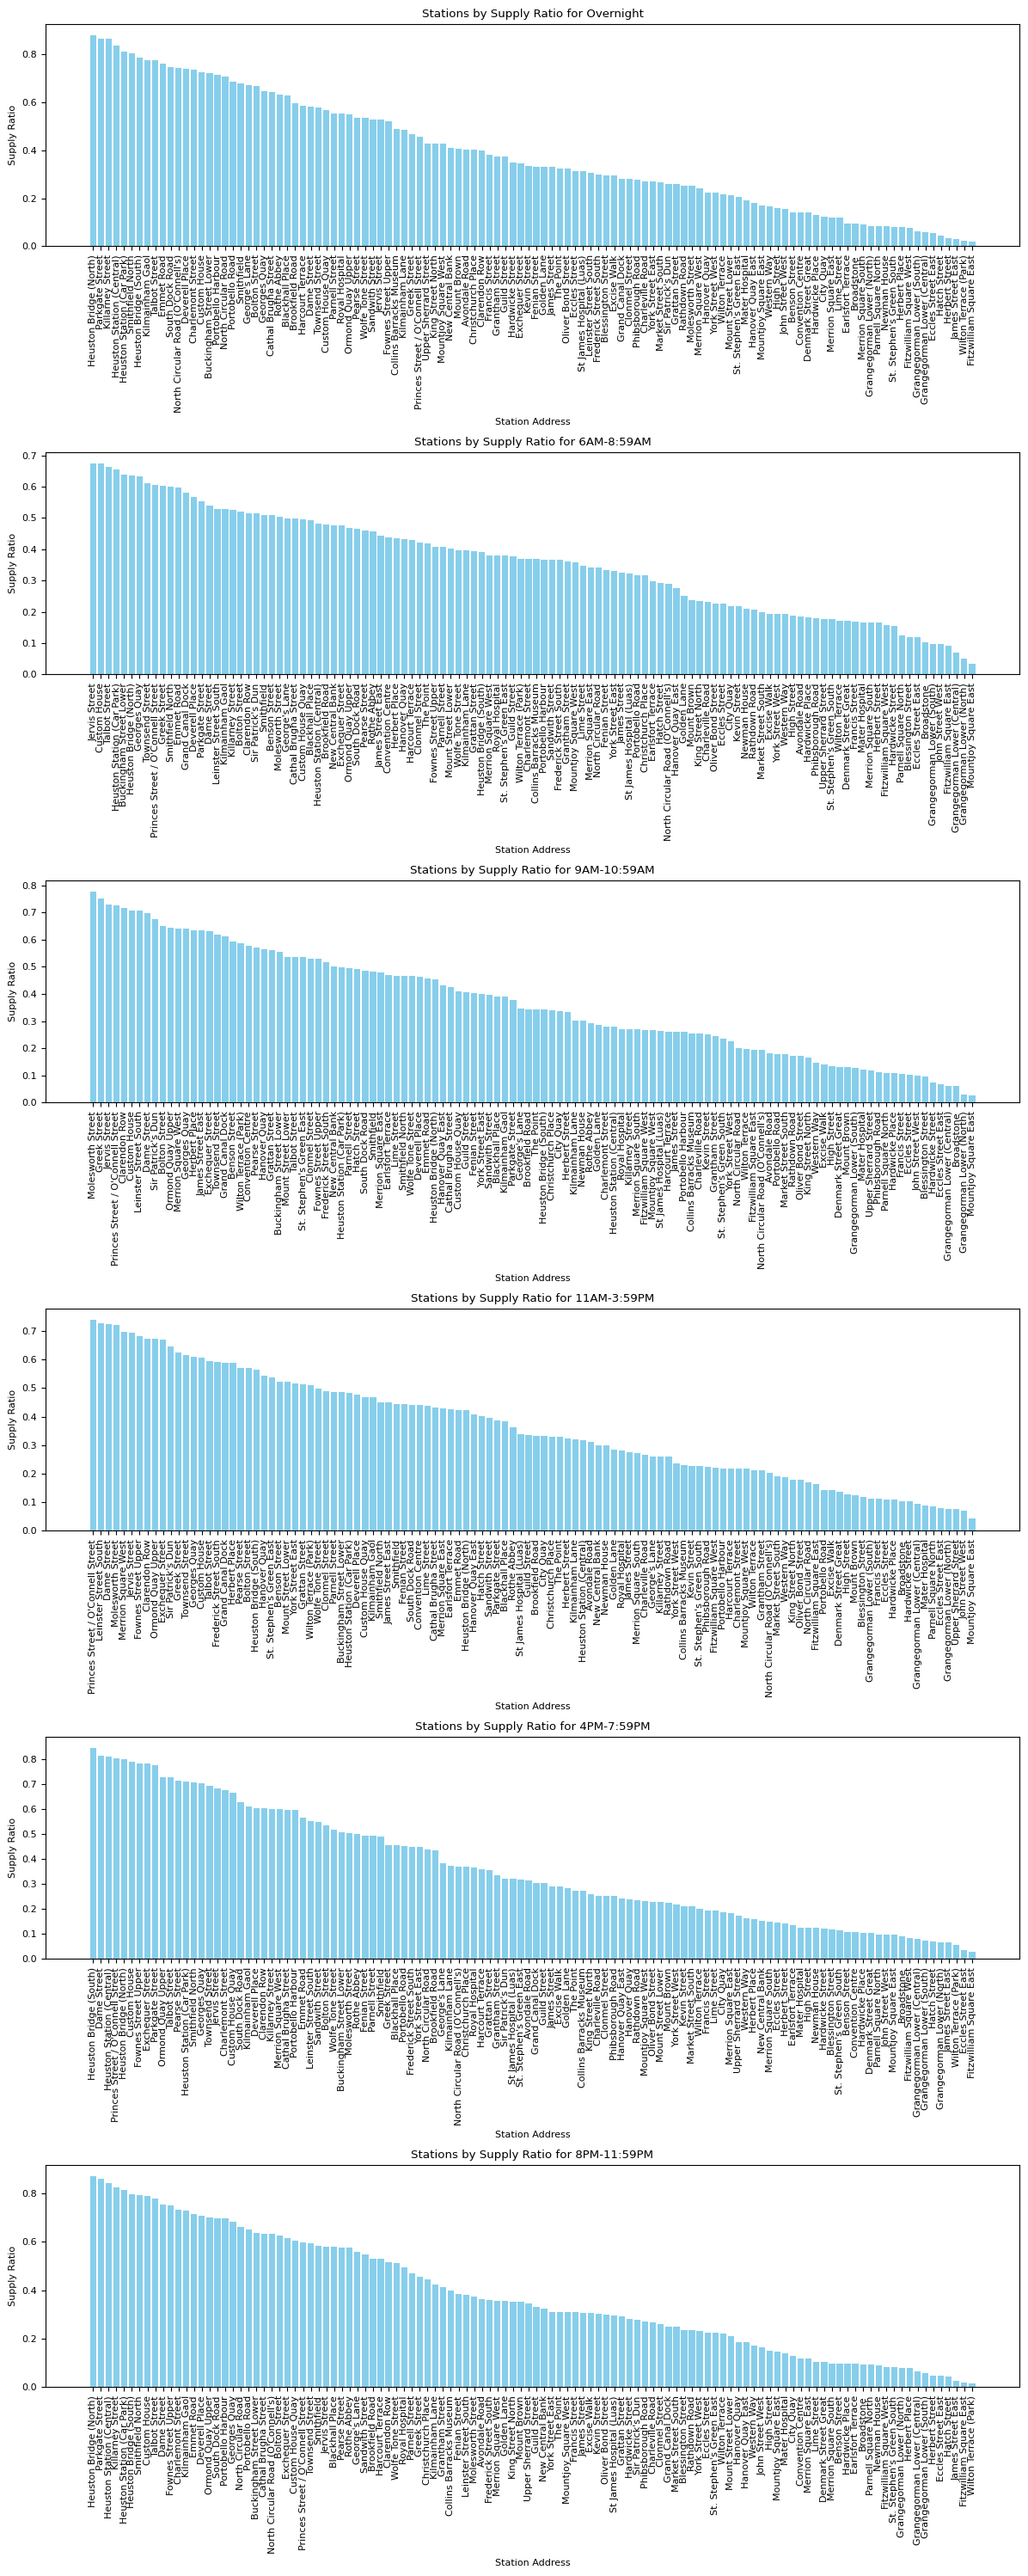

In [38]:
# Group by 'address' and calculate the total available bikes and bike stands for each station
sub_df_address_group = df24_bike.groupby(['address', 'time_category']).agg({'num_bikes_available': 'sum', 'capacity': 'sum'}).reset_index()
# sub_df_address_group_time_group = df24_bike.groupby(['time_category']).agg({'num_bikes_available': 'sum', 'capacity': 'sum'}).reset_index()

# Calculate the supply ratio for each station
sub_df_address_group['supply_ratio'] = sub_df_address_group['num_bikes_available'] / sub_df_address_group['capacity']
# sub_df_address_group_time_group['supply_ratio'] = sub_df_address_group_time_group['num_bikes_available'] / sub_df_address_group_time_group['capacity']

# Get the addresses of the top 10 stations by supply ratio (ascending)
address_names = top_10_std_dev['address'].tolist()

# Create a subset of sub_df for the top 10 stations (ascending)
top_10_subset = sub_df_address_group[sub_df_address_group['address'].isin(address_names)]

# Order data in desc format
top_10_subset = top_10_subset.sort_values(by='supply_ratio', ascending=False)


#  time categories
time_categories = ['Overnight', '6AM-8:59AM', '9AM-10:59AM', '11AM-3:59PM', '4PM-7:59PM', '8PM-11:59PM']

# Create subplots
plt.rcParams.update({'font.size': 8})
fig, axes = plt.subplots(len(time_categories), 1, figsize=(12, 5 * len(time_categories)))

# Iterate and plot
for i, time_cat in enumerate(time_categories):
    subset = top_10_subset[top_10_subset['time_category'] == time_cat]
    axes[i].bar(subset['address'], subset['supply_ratio'], color='skyblue')
    axes[i].set_title(f'Stations by Supply Ratio for {time_cat}')
    axes[i].set_ylabel('Supply Ratio')
    axes[i].set_xlabel('Station Address')
    axes[i].tick_params(axis='x', rotation=90, labelrotation=90)


# Adjust layout
plt.tight_layout()
plt.show()

15


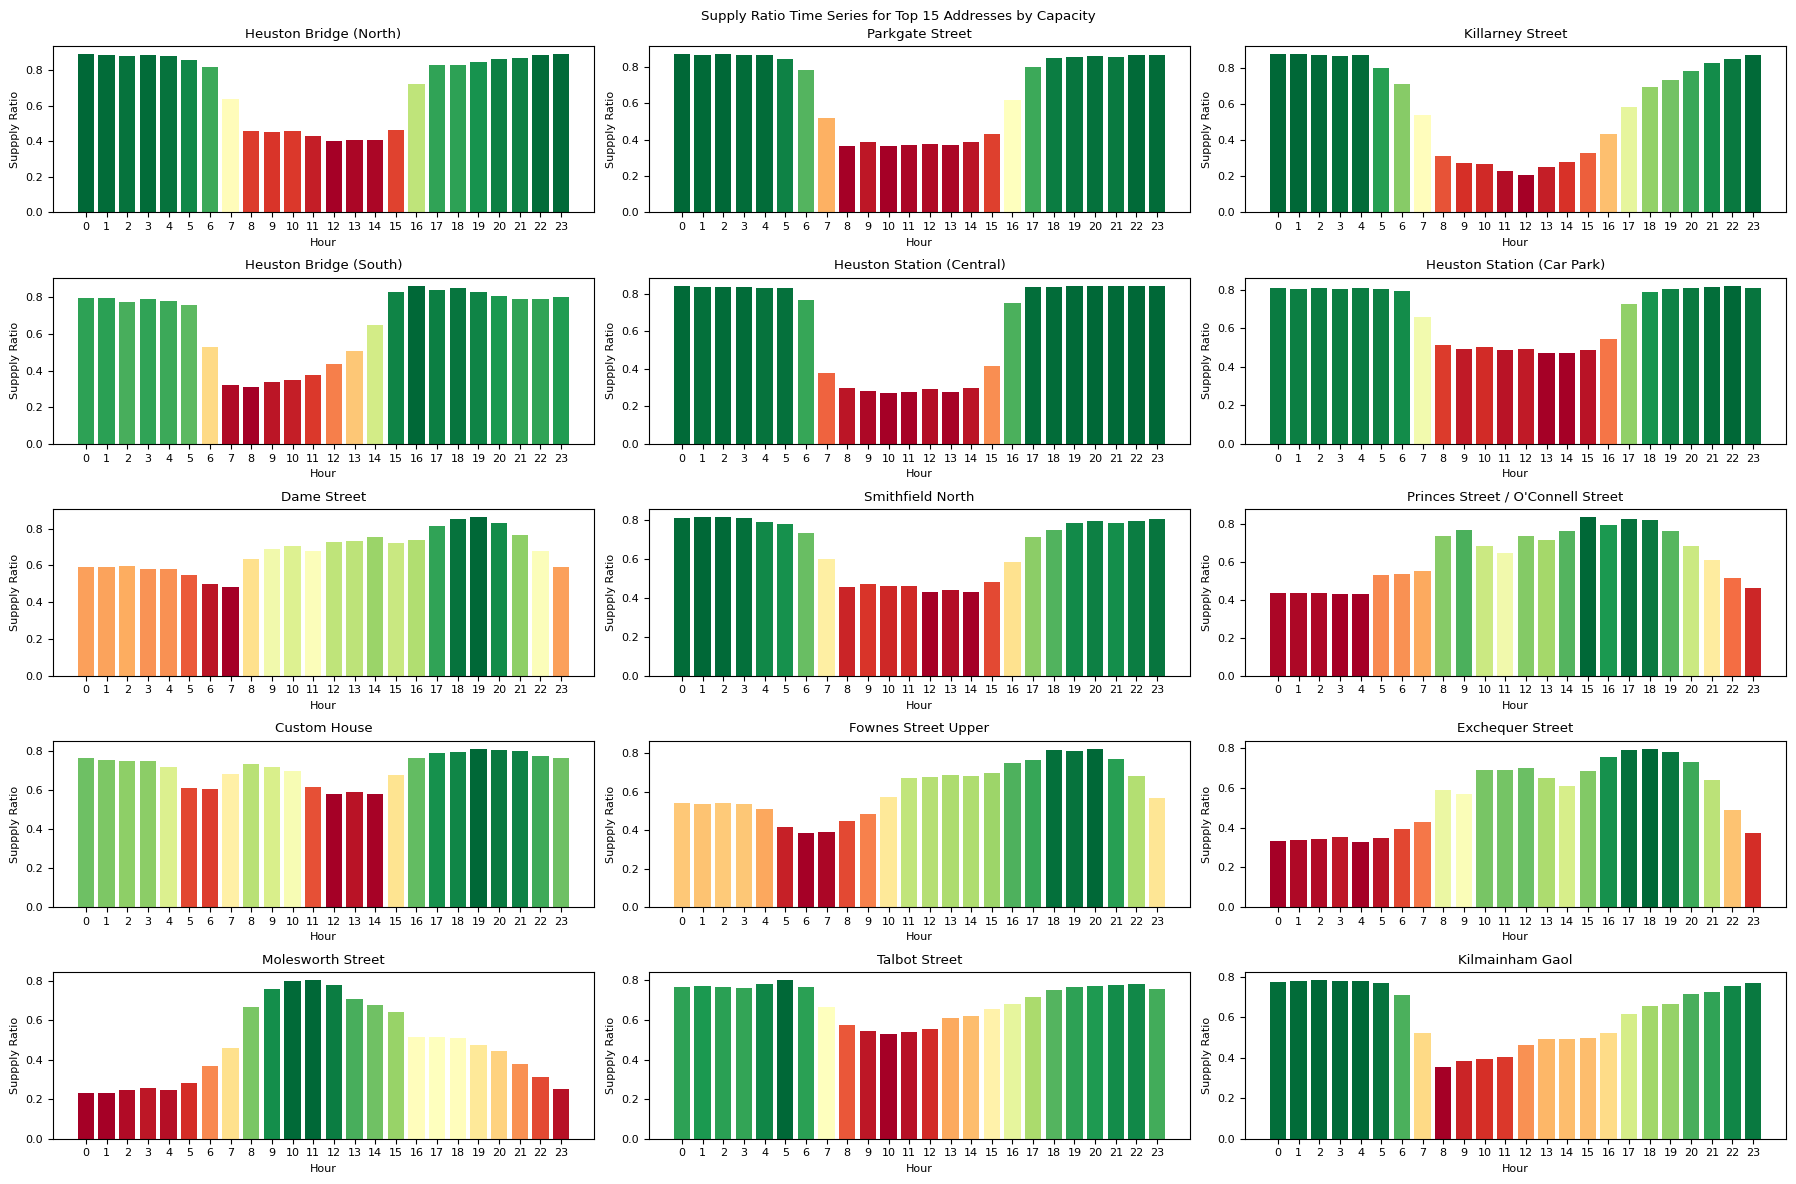

In [39]:
# get unique address list
top_10_addresses = []
for address in top_10_subset['address']:
    if address not in top_10_addresses:
        top_10_addresses.append(address)
top_10_addresses = top_10_addresses[:15]
print(len(top_10_addresses))

# Group by 'hour' and 'address' and aggregate sum
sub_df_hour = df24_bike.groupby(['hour', 'address']).agg({'num_bikes_available': 'sum', 'capacity': 'sum'}).reset_index()

# Calculate 'supply_ratio' for sub_df_hour
sub_df_hour['supply_ratio'] = sub_df_hour['num_bikes_available'] / sub_df_hour['capacity']

# Filter to only include addresses from top_10_addresses
sub_df_hour_top_10 = sub_df_hour[sub_df_hour['address'].isin(top_10_addresses)]

fig, axes = plt.subplots(5, 3, figsize=(18, 12))
fig.suptitle('Supply Ratio Time Series for Top 15 Addresses by Capacity')  # Update the title

# Using a colormap that transitions from red to yellow to green
cmap = plt.cm.RdYlGn

# Loop through the top 9 addresses
for i, address in enumerate(top_10_addresses):  # Exclude the 10th address
    ax = axes[i//3, i%3]
    data = sub_df_hour_top_10[sub_df_hour_top_10['address'] == address]

    min_ratio = data['supply_ratio'].min()
    max_ratio = data['supply_ratio'].max()

    # Normalize the supply ratio for color mapping
    normalized_ratios = (data['supply_ratio'] - min_ratio) / (max_ratio - min_ratio)

    # Bar plot for each address with gradient colors
    bar_colors = cmap(normalized_ratios)
    ax.bar(data['hour'], data['supply_ratio'], color=bar_colors)

    ax.set_title(address)
    ax.set_xlabel('Hour')
    ax.set_ylabel('Suppply Ratio')

    # Set x-axis ticks and labels for each hour
    ax.set_xticks(data['hour'])
    ax.set_xticklabels(data['hour'])

# Remove any unused subplots (in case you have less than 9 addresses)
for i in range(len(top_10_addresses), 15):
    axes[i//3, i%3].axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Adjust the top space so the suptitle doesn't overlap
plt.show()

15


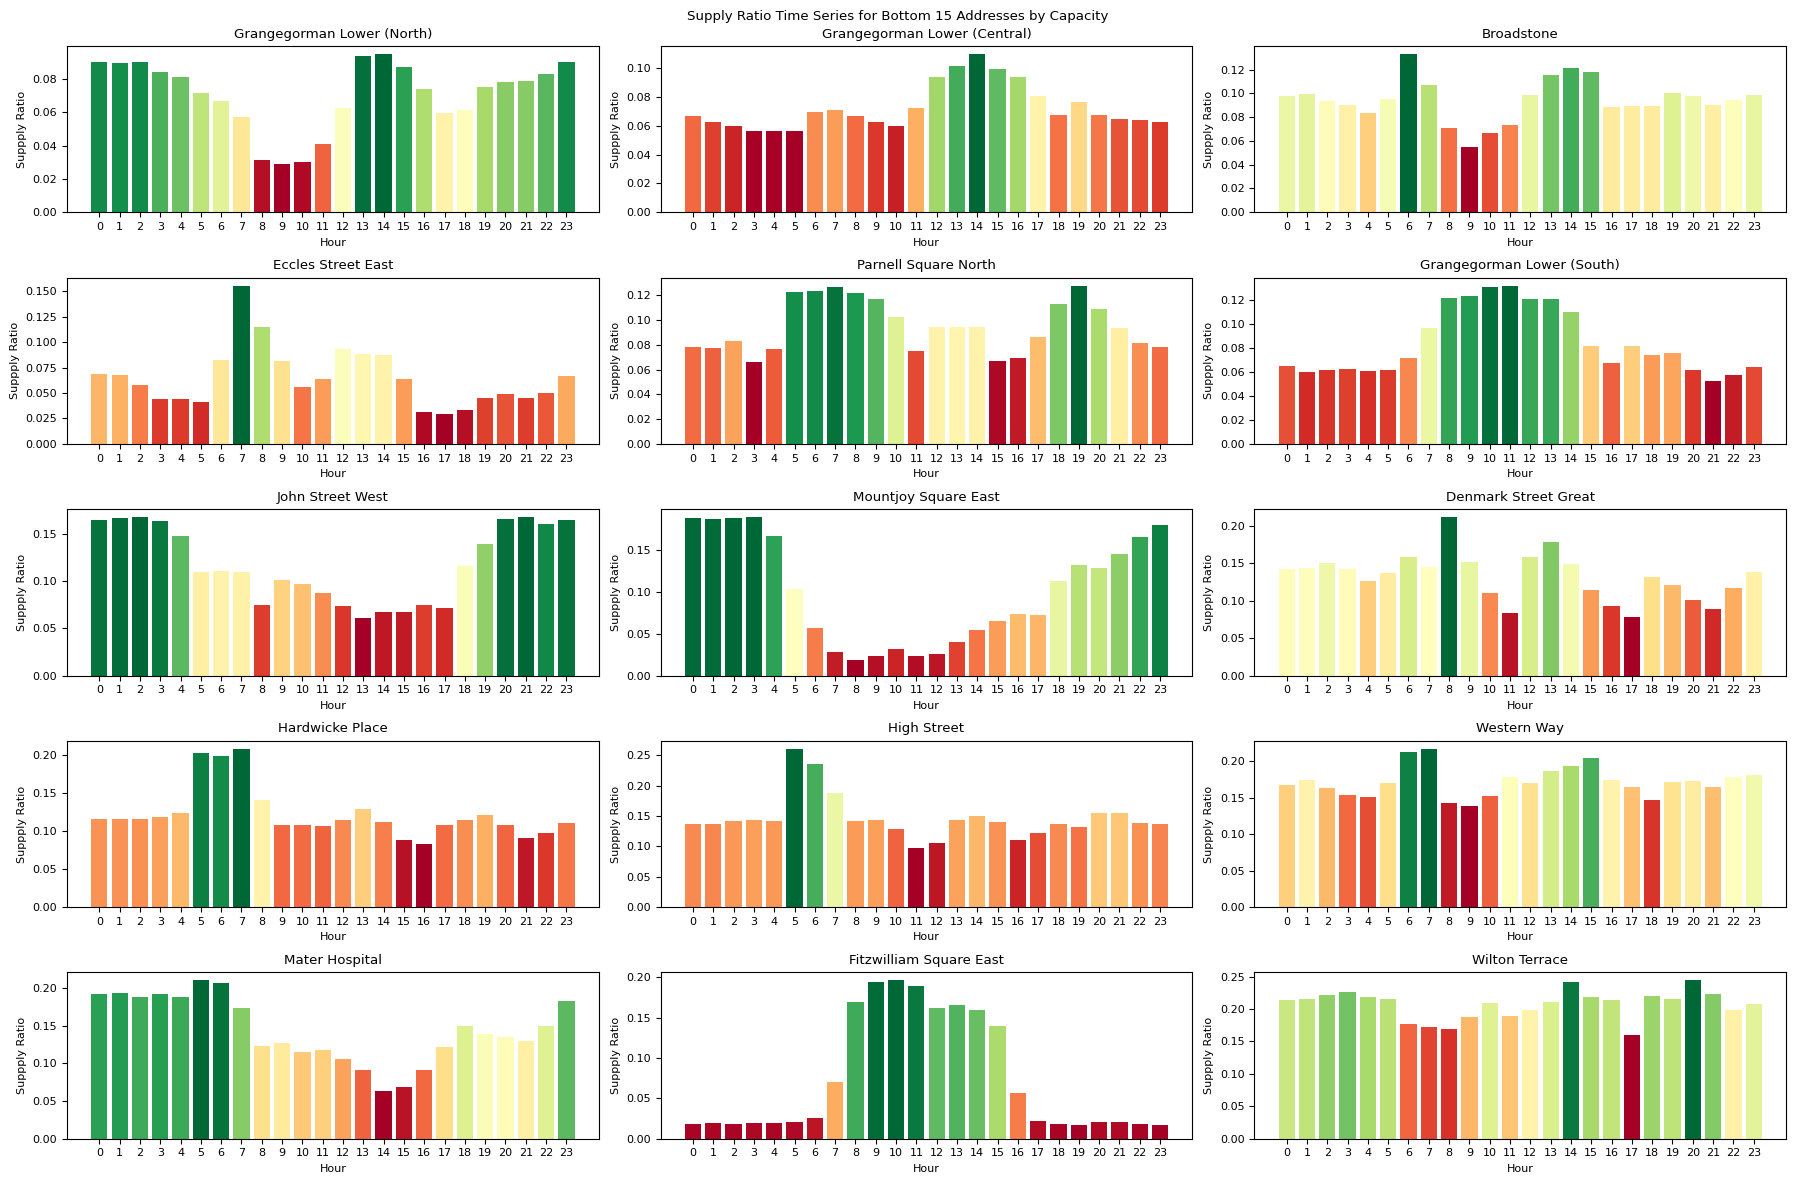

In [40]:
# get unique address list
top_10_addresses = []
for address in top_10_subset['address']:
    if address not in top_10_addresses:
        top_10_addresses.append(address)
top_10_addresses = top_10_addresses[-15:][::-1]
print(len(top_10_addresses))

# Group by 'hour' and 'address' and aggregate sum
sub_df_hour = df24_bike.groupby(['hour', 'address']).agg({'num_bikes_available': 'sum', 'capacity': 'sum'}).reset_index()

# Calculate 'supply_ratio' for sub_df_hour
sub_df_hour['supply_ratio'] = sub_df_hour['num_bikes_available'] / sub_df_hour['capacity']

# Filter to only include addresses from top_10_addresses
sub_df_hour_top_10 = sub_df_hour[sub_df_hour['address'].isin(top_10_addresses)]

fig, axes = plt.subplots(5, 3, figsize=(18, 12))
fig.suptitle('Supply Ratio Time Series for Bottom 15 Addresses by Capacity')  # Update the title

# Using a colormap that transitions from red to yellow to green
cmap = plt.cm.RdYlGn

# Loop through the top 9 addresses
for i, address in enumerate(top_10_addresses):  # Exclude the 10th address
    ax = axes[i//3, i%3]
    data = sub_df_hour_top_10[sub_df_hour_top_10['address'] == address]

    min_ratio = data['supply_ratio'].min()
    max_ratio = data['supply_ratio'].max()

    # Normalize the supply ratio for color mapping
    normalized_ratios = (data['supply_ratio'] - min_ratio) / (max_ratio - min_ratio)

    # Bar plot for each address with gradient colors
    bar_colors = cmap(normalized_ratios)
    ax.bar(data['hour'], data['supply_ratio'], color=bar_colors)

    ax.set_title(address)
    ax.set_xlabel('Hour')
    ax.set_ylabel('Suppply Ratio')

    # Set x-axis ticks and labels for each hour
    ax.set_xticks(data['hour'])
    ax.set_xticklabels(data['hour'])

# Remove any unused subplots (in case you have less than 9 addresses)
for i in range(len(top_10_addresses), 15):
    axes[i//3, i%3].axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Adjust the top space so the suptitle doesn't overlap
plt.show()

Clustering similar Stations

In [41]:
df24_bike.head(1)

,system_id,last_reported,station_id,num_bikes_available,num_docks_available,is_installed,is_renting,is_returning,name,short_name,...,lon,region_id,capacity,hour,date_hour,week_day,day_type,supply_ratio,time_category,cluster_group
0,dublin_bikes,2024-05-02 19:00:00,109,10,18,True,True,True,BUCKINGHAM STREET LOWER,NaN,...,-6.249319,NaN,29,19,2024-05-02 19,Thursday,Weekday,0.344828,4PM-7:59PM,4PM-7:59PM Weekday


In [42]:
#group data into clusters
clustering_df = df24_bike[['station_id', 'name', 'lat', 'lon', 'day_type', 'time_category', 'supply_ratio', 'cluster_group']]
clustering_df = clustering_df.groupby(['station_id', 'name', 'lat', 'lon','cluster_group'],as_index=False)['supply_ratio'].mean()
clustering_df  = clustering_df.set_index('station_id')

#pivot dataframe for clustering
clustering_df = clustering_df.pivot_table(index= ['name', 'station_id', 'lat', 'lon'] , columns=['cluster_group'], values='supply_ratio')
clustering_df  = clustering_df.reset_index()
clustering_df  = clustering_df.set_index('name')
clustering_df = clustering_df.dropna()

clustering_df.sample(10)

cluster_group,station_id,lat,lon,11AM-3:59PM Weekday,11AM-3:59PM Weekend,4PM-7:59PM Weekday,4PM-7:59PM Weekend,6AM-8:59AM Weekday,6AM-8:59AM Weekend,8PM-11:59PM Weekday,8PM-11:59PM Weekend,9AM-10:59AM Weekday,9AM-10:59AM Weekend,Overnight Weekday,Overnight Weekend
name,,,,,,,,,,,,,,,
SANDWITH STREET,64,53.345203,-6.247163,0.405229,0.364003,0.595688,0.392553,0.351411,0.418373,0.605424,0.373392,0.380758,0.443217,0.567521,0.420726
KEVIN STREET,71,53.337757,-6.267699,0.183343,0.354206,0.164747,0.357186,0.165432,0.392751,0.250238,0.451036,0.217523,0.345588,0.294582,0.446909
UPPER SHERRARD STREET,44,53.358437,-6.260641,0.083455,0.054961,0.180480,0.156493,0.145214,0.269680,0.376098,0.260075,0.102941,0.156932,0.445251,0.385070
SMITHFIELD,35,53.347690,-6.278214,0.361832,0.680058,0.435172,0.653856,0.418991,0.812477,0.554845,0.660526,0.359280,0.801918,0.637694,0.785794
MERRION SQUARE SOUTH,113,53.338615,-6.248606,0.315452,0.155364,0.144515,0.162976,0.176377,0.135035,0.069399,0.181291,0.316579,0.133911,0.074694,0.135634
YORK STREET WEST,51,53.339333,-6.264699,0.227789,0.261316,0.191919,0.289502,0.183969,0.216827,0.202833,0.312952,0.229273,0.218750,0.228162,0.210684
CHRISTCHURCH PLACE,6,53.343370,-6.270120,0.248832,0.536637,0.282286,0.637247,0.199705,0.646389,0.344838,0.726571,0.241961,0.577308,0.289795,0.696089
CLONMEL STREET,54,53.336020,-6.262980,0.530618,0.371132,0.232339,0.313814,0.413081,0.445455,0.218235,0.378340,0.569779,0.428495,0.228049,0.411218
WESTERN WAY,102,53.354930,-6.269425,0.185309,0.190433,0.164444,0.166395,0.194231,0.186935,0.182701,0.140686,0.121303,0.211343,0.166521,0.166239


K-Means Clustering Analysis

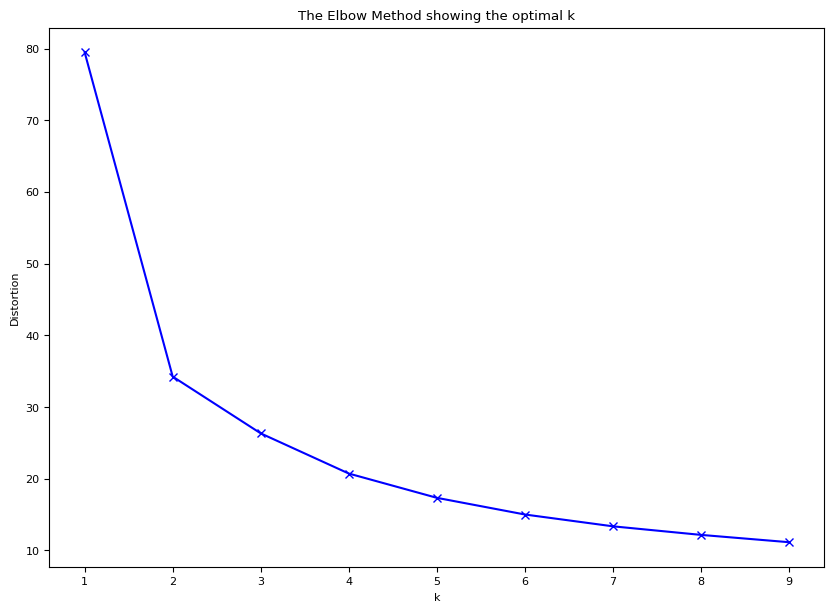

In [43]:
distortions = []
K = range(1,10)
X = np.array(clustering_df.drop(['station_id', 'lat', 'lon'], axis=1).astype(float))
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(10,7))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [44]:
#clustering algo
X = np.array(clustering_df.drop(['station_id', 'lat', 'lon'], axis=1).astype(float))
KM = KMeans(n_clusters=5)
KM.fit(X)
clusters = KM.predict(X)

locations = clustering_df
locations['cluster'] = clusters
locations = locations.reset_index()
locations.head(5)

cluster_group,name,station_id,lat,lon,11AM-3:59PM Weekday,11AM-3:59PM Weekend,4PM-7:59PM Weekday,4PM-7:59PM Weekend,6AM-8:59AM Weekday,6AM-8:59AM Weekend,8PM-11:59PM Weekday,8PM-11:59PM Weekend,9AM-10:59AM Weekday,9AM-10:59AM Weekend,Overnight Weekday,Overnight Weekend,cluster
0,AVONDALE ROAD,108,53.359406,-6.276142,0.336924,0.244112,0.341437,0.242796,0.150644,0.281583,0.398513,0.265588,0.149540,0.266010,0.417035,0.367021,3
1,BENSON STREET,90,53.344154,-6.233451,0.649178,0.131349,0.092507,0.154046,0.576682,0.249566,0.062984,0.206250,0.740863,0.168067,0.111368,0.220597,0
2,BLACKHALL PLACE,88,53.348800,-6.281637,0.336316,0.507251,0.434811,0.511243,0.490135,0.504734,0.581211,0.577905,0.334820,0.537097,0.660055,0.542096,3
3,BLESSINGTON STREET,2,53.356770,-6.268140,0.140977,0.051957,0.114286,0.131395,0.133964,0.076846,0.265737,0.159006,0.117966,0.032857,0.325605,0.212983,2
4,BOLTON STREET,3,53.351180,-6.269859,0.569412,0.572785,0.489874,0.670325,0.466023,0.685345,0.599504,0.701337,0.682386,0.559091,0.621663,0.787705,1


In [45]:
colordict = {0: 'blue', 1: 'red', 2: 'orange', 3: 'green', 4: 'purple'}
dublin_map = folium.Map([53.3498, -6.2603], zoom_start=14)
for lat, long, cluster in zip(locations['lat'],locations['lon'], locations['cluster']):
    folium.CircleMarker(
        [lat, long],
        color = 'b',
        radius = 8,
        fill_color=colordict[cluster],
        fill=True,
        fill_opacity=0.9
        ).add_to(dublin_map)
dublin_map

In [46]:
#merge clusters back into main dataset

merged_with_clusters = df24_bike.copy()
cluster_output = locations[['station_id', 'cluster']]
cluster_output.drop_duplicates(keep = 'first', inplace = True)
merged_with_clusters = pd.merge (merged_with_clusters, cluster_output, on = 'station_id', how = 'left')
# merged_with_clusters['BIKE_ARR_DEP_ABS'] = abs(merged_with_clusters['BIKE_ARR_DEP'])
merged_with_clusters.sample(5)

,system_id,last_reported,station_id,num_bikes_available,num_docks_available,is_installed,is_renting,is_returning,name,short_name,...,region_id,capacity,hour,date_hour,week_day,day_type,supply_ratio,time_category,cluster_group,cluster
74117,dublin_bikes,2024-05-06 19:30:00,68,0,40,True,True,True,HANOVER QUAY,NaN,...,NaN,40,19,2024-05-06 19,Monday,Weekday,0.00000,4PM-7:59PM,4PM-7:59PM Weekday,0
181698,dublin_bikes,2024-05-11 22:50:00,63,7,28,True,True,True,FENIAN STREET,NaN,...,NaN,35,22,2024-05-11 22,Saturday,Weekend,0.20000,8PM-11:59PM,8PM-11:59PM Weekend,3
231048,dublin_bikes,2024-05-14 10:45:00,77,11,18,True,True,True,WOLFE TONE STREET,NaN,...,NaN,29,10,2024-05-14 10,Tuesday,Weekday,0.37931,9AM-10:59AM,9AM-10:59AM Weekday,1
171473,dublin_bikes,2024-05-11 11:10:00,67,0,40,True,True,True,THE POINT,NaN,...,NaN,40,11,2024-05-11 11,Saturday,Weekend,0.00000,11AM-3:59PM,11AM-3:59PM Weekend,0
90091,dublin_bikes,2024-05-07 14:35:00,69,17,23,True,True,True,GRAND CANAL DOCK,NaN,...,NaN,40,14,2024-05-07 14,Tuesday,Weekday,0.42500,11AM-3:59PM,11AM-3:59PM Weekday,0


In [47]:
# defining the cluster labels
merged_with_clusters[['name', 'cluster']].sample(30)

,name,cluster
538935,ROYAL HOSPITAL,3
378896,EXCISE WALK,2
530095,MOUNTJOY SQUARE WEST,3
178537,FENIAN STREET,3
231905,WOLFE TONE STREET,1
516363,PARKGATE STREET,4
538644,SOUTH DOCK ROAD,4
111429,FOWNES STREET UPPER,1
221220,CATHAL BRUGHA STREET,4
421221,SANDWITH STREET,3


       day_type         cluster  hour  supply_ratio
19569   Weekend    South Dublin     0      0.677419
19570   Weekend    South Dublin     0      0.687500
19571   Weekend           Outer     0      0.880000
19572   Weekend    North Dublin     0      0.075000
19573   Weekend    North Dublin     0      0.325000
...         ...             ...   ...           ...
490737  Weekend           Outer    23      0.625000
490738  Weekend           Outer    23      0.150000
490739  Weekend           Outer    23      0.750000
490740  Weekend  Train Stations    23      0.233333
490741  Weekend           Outer    23      0.725000

[155941 rows x 4 columns]


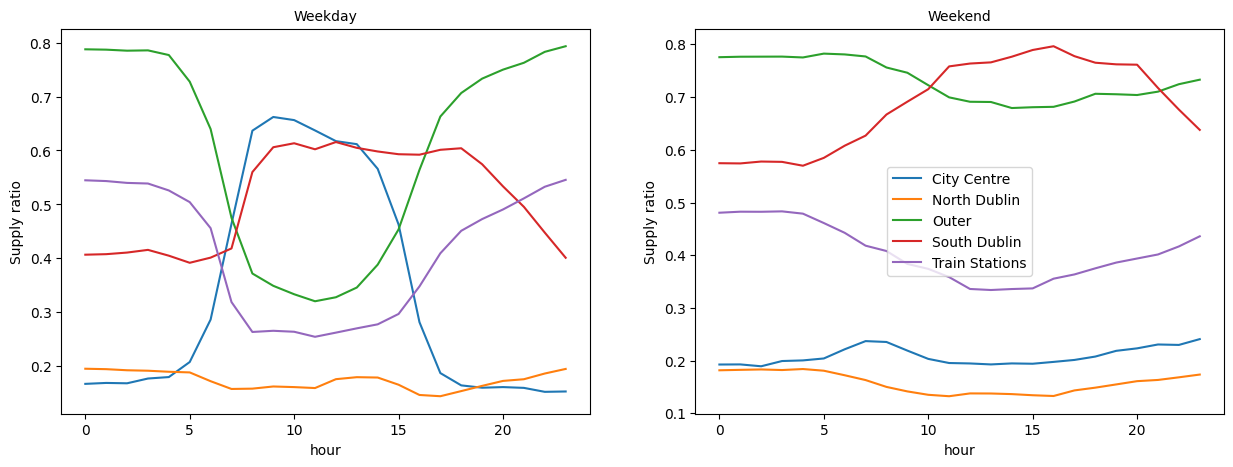

In [48]:
linechart_data = merged_with_clusters[['day_type', 'cluster', 'hour', 'supply_ratio']]
linechart_data['cluster'] = np.where(linechart_data['cluster'] == 0, 'City Centre',
                                    np.where(linechart_data['cluster'] == 1, 'South Dublin',
                                            np.where(linechart_data['cluster'] == 2, 'North Dublin',
                                                    np.where(linechart_data['cluster'] == 3, 'Train Stations', 'Outer'))))

#Weekday
linechart_data_weekday = linechart_data[linechart_data['day_type'] == 'Weekday']
linechart_data_weekday = linechart_data_weekday.groupby(['hour', 'cluster'])['supply_ratio'].mean()
linechart_data_weekday  = linechart_data_weekday.reset_index()
y1 = linechart_data_weekday['supply_ratio'].values
x1 = linechart_data_weekday['hour'].values
labels1 = linechart_data_weekday['cluster'].values
colours1 = linechart_data_weekday['cluster'].values
df1 = pd.DataFrame(dict(x=x1, y=y1, label=labels1))
groups1 = df1.groupby('label')

#Weekend
linechart_data_weekend = linechart_data[linechart_data['day_type'] == 'Weekend']
print(linechart_data_weekend)
linechart_data_weekend = linechart_data_weekend.groupby(['hour', 'cluster'])['supply_ratio'].mean()
linechart_data_weekend  = linechart_data_weekend.reset_index()
y2 = linechart_data_weekend['supply_ratio'].values
x2 = linechart_data_weekend['hour'].values
labels2 = linechart_data_weekend['cluster'].values
colours2 = linechart_data_weekend['cluster'].values
df2 = pd.DataFrame(dict(x=x2, y=y2, label=labels2))
groups2 = df2.groupby('label')

import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

SMALL_SIZE = 10
MEDIUM_SIZE = 10
BIGGER_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


fig, axs = plt.subplots(1, 2, figsize=(15, 5))
for name, group in groups1:
    axs[0].plot(group.x, group.y, label=name)
    axs[0].set_title('Weekday')
    axs[0].set_xlabel('hour')
    axs[0].set_ylabel('Supply ratio')

for name, group in groups2:
    axs[1].plot(group.x, group.y, label=name)
    axs[1].set_title('Weekend')
    axs[1].set_xlabel('hour')
    axs[1].set_ylabel('Supply ratio')
    axs[1].legend()

plt.show()

In [49]:
df24_weather_extended = df24_weather.copy()

# Create a dummy row with the last timestamp + 30 minutes
last_row = df24_weather_extended.iloc[-1].copy()
last_row['date'] = pd.to_datetime(last_row['date']) + pd.Timedelta(minutes=30)
df24_weather_extended.loc[-1] = last_row

#First, convert the 'time' column in df24_weather_extended to datetime objects and set it as the index.
df24_weather_extended['date'] = pd.to_datetime(df24_weather_extended['date'])
df24_weather_extended.set_index('date', inplace=True)

# Then, resample the DataFrame to 5-minute intervals and interpolate the missing values.
df24_weather_resampled = df24_weather_extended.resample('5T').interpolate()

# columns were dropped during the resampling and interpolation process because they contain string values, which cannot be interpolated directly.
# fill the missing values in 'weather_main' and 'weather_description' with the last known value
df24_weather_resampled['weather_main'] = df24_weather_resampled['weather_main'].ffill()
df24_weather_resampled['weather_description'] = df24_weather_resampled['weather_description'].ffill()

# Finally, reset the index to have 'time' as a column again.
df24_weather_resampled.reset_index(inplace=True)
df24_weather_resampled['date'] = df24_weather_resampled['date'].dt.strftime('%Y-%m-%d %H:%M:%S')

# Remove the dummy row
df24_weather_resampled = df24_weather_resampled[:-1]

# Now, df24_weather_resampled contains weather data at 5-minute intervals.
df24_weather_resampled

NameError: name 'df24_weather' is not defined

In [ ]:
# merge bike data with weather data
df24_merge = pd.merge(df24, df24_weather_resampled, left_on='last_reported', right_on='date', how='left')
df24_merge

In [ ]:
df24_merge[596226:]

In [ ]:
bike_dataset = df24_merge.copy()

# lets improve the date fields to break it down for later analysis
bike_dataset['YEAR'] = pd.to_datetime(bike_dataset['last_reported']).apply(lambda x: x.strftime('%Y'))
bike_dataset['MONTH'] = pd.to_datetime(bike_dataset['last_reported']).apply(lambda x: x.strftime('%m'))
bike_dataset['DAY'] = pd.to_datetime(bike_dataset['last_reported']).apply(lambda x: x.strftime('%d'))
bike_dataset['HOUR'] = pd.to_datetime(bike_dataset['last_reported']).apply(lambda x: x.strftime('%H'))
bike_dataset['MINUTES'] = pd.to_datetime(bike_dataset['last_reported']).apply(lambda x: x.strftime('%M'))
#add day of the week to the dataset
bike_dataset['WEEKDAY'] = pd.to_datetime(bike_dataset['last_reported']).dt.dayofweek

bike_dataset

In [ ]:
# stations
stations = bike_dataset[['station_id', 'lat', 'lon', 'name', 'address']].copy().drop_duplicates(subset=['station_id'], keep='first')
# reset df to have sequential index
stations = stations.reset_index(drop=True)
stations

In [ ]:
m = leafmap.Map(toolbar_control=False, layers_control=True, center=[53.3498, -6.2603], zoom=12)
m.add_osm_from_geocode('Dublin', layer_name='Dublin')
m.add_points_from_xy(stations, x='lon', y='lat', layer_name='Stations')
m

In [ ]:
# create a figure and axis
fig, ax = plt.subplots()

# BIKES AVAILABLE VS MONTH
# scatter the month against the available_bikes
ax.scatter(bike_dataset['WEEKDAY'], bike_dataset['num_bikes_available'])
# set a title and labels
ax.set_title('Bikes available per weekday')
ax.set_xlabel('weeda')
ax.set_ylabel('available bikes')

In [ ]:
# BIKES AVAILABLE VS DAY
fig, ax = plt.subplots()
ax.scatter(bike_dataset['DAY'], bike_dataset['num_bikes_available'])
ax.set_title('Bikes available per day')
ax.set_xlabel('day')
ax.set_ylabel('available bikes')

In [ ]:
# BIKES AVAILABLE VS HOUR
fig, ax = plt.subplots()
ax.scatter(bike_dataset['HOUR'], bike_dataset['num_bikes_available'])
ax.set_title('Bikes available per hour')
ax.set_xlabel('hour')
ax.set_ylabel('available bikes')

In [ ]:
# BIKES AVAILABLE VS DAY OF THE WEEK
fig, ax = plt.subplots()
ax.scatter(bike_dataset['WEEKDAY'], bike_dataset['num_bikes_available'])
ax.set_title('Bikes available per day of the week')
ax.set_xlabel('day of the week 0: Monday - 6: Sunday')
ax.set_ylabel('available bikes')

In [ ]:
bike_dataset[:1]

In [ ]:
# BIKES AVAILABLE VS TEMPERATURE
fig, ax = plt.subplots()
ax.scatter(bike_dataset['temp'], bike_dataset['num_bikes_available'])
ax.set_title('Bikes available per temperature')
ax.set_xlabel('temperature')
ax.set_ylabel('available bikes')

In [ ]:
# BIKES AVAILABLE VS FEELS LIKE
fig, ax = plt.subplots()
ax.scatter(bike_dataset['feels_like'], bike_dataset['num_bikes_available'])
ax.set_title('Bikes available per feels like temperature')
ax.set_xlabel('feels like temperature')
ax.set_ylabel('available bikes')

In [ ]:
# BIKES AVAILABLE VS PRESSURE
fig, ax = plt.subplots()
ax.scatter(bike_dataset['pressure'], bike_dataset['num_bikes_available'])
ax.set_title('Bikes available per pressure')
ax.set_xlabel('pressure')
ax.set_ylabel('available bikes')

In [ ]:
# BIKES AVAILABLE VS HUMIDITY
fig, ax = plt.subplots()
ax.scatter(bike_dataset['humidity'], bike_dataset['num_bikes_available'])
ax.set_title('Bikes available per humidity')
ax.set_xlabel('humidity')
ax.set_ylabel('available bikes')

In [ ]:
# BIKES AVAILABLE VS WIND SPEED
fig, ax = plt.subplots()
ax.scatter(bike_dataset['wind_speed'], bike_dataset['num_bikes_available'])
ax.set_title('Bikes available per Wind speed')
ax.set_xlabel('wind_speed')
ax.set_ylabel('available bikes')

In [ ]:
# BIKES AVAILABLE VS WIND DIRECTION
fig, ax = plt.subplots()
ax.scatter(bike_dataset['wind_deg'], bike_dataset['num_bikes_available'])
ax.set_title('Bikes available per Wind direction')
ax.set_xlabel('wind direction')
ax.set_ylabel('available bikes')